In [4]:
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import statsmodels.formula.api as smf
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
%matplotlib inline

original data from https://www.kaggle.com/austinreese/craigslist-carstrucks-data
then I cleaned it with Tableau prep: deteted columns with url, left only rows with 100 <= price <= 235000 
and rows where 1950 <= year <= 2018, 
cleaned manufacturer column: combined misspeled (e.g. mercedes-benz and mercedes), tried to extract some missing from make column 

In [5]:
data = pd.read_csv('Output_used_cars_craigslist.csv', sep=';')

C:\Users\julij\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3057: DtypeWarning: Columns (6,13,14) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


# EDA, cleaning ant transforming variables

In [6]:
len(data)/1000000

1.679607

In [7]:
data.head()

,state_name,city,manufacturer,year,price,make,condition,cylinders,fuel,odometer,...,size,type,paint_color,lat,long,county_fips,county_name,state_fips,state_code,weather
0,FAILED,montreal,Undefined,1967-01-01,16500,Corvair stinger,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,"45,597425","-73,563924",NaN,NaN,NaN,NaN,NaN
1,FAILED,montreal,Undefined,2001-01-01,10499,Oldsmobile Aurora,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,"45,504822","-73,664273",NaN,NaN,NaN,NaN,NaN
2,FAILED,montreal,Undefined,2001-01-01,10499,Oldsmobile Aurora,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,"45,504822","-73,664273",NaN,NaN,NaN,NaN,NaN
3,FAILED,montreal,Undefined,2002-01-01,14888,77241,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,"45,358469","-73,476415",NaN,NaN,NaN,NaN,NaN
4,FAILED,montreal,Undefined,2003-01-01,2800,Accord 2003,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,"45,500616","-73,787199",NaN,NaN,NaN,NaN,NaN


In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1679607 entries, 0 to 1679606
Data columns (total 24 columns):
state_name      1679607 non-null object
city            1679607 non-null object
manufacturer    1679607 non-null object
year            1679607 non-null object
price           1679607 non-null int64
make            1615011 non-null object
condition       1000450 non-null object
cylinders       1009997 non-null object
fuel            1669468 non-null object
odometer        1142985 non-null float64
title_status    1677081 non-null object
transmission    1670619 non-null object
vin             595861 non-null object
drive           1040192 non-null object
size            586613 non-null object
type            1000821 non-null object
paint_color     1007117 non-null object
lat             1679607 non-null object
long            1679607 non-null object
county_fips     1621052 non-null float64
county_name     1621052 non-null object
state_fips      1621052 non-null float64
state_c

In [ ]:
#I will need new variable - 'age', to calculate it, I first need to convert year into integer

In [9]:
data['year'] = data['year'].apply(lambda x: int(x[0:4]))

In [10]:
data['age'] = 2018 - data['year']

In [11]:
# missing values (mean shows percentage from whole)
data.isnull().mean()

state_name      0.000000
city            0.000000
manufacturer    0.000000
year            0.000000
price           0.000000
make            0.038459
condition       0.404355
cylinders       0.398671
fuel            0.006037
odometer        0.319493
title_status    0.001504
transmission    0.005351
vin             0.645238
drive           0.380693
size            0.650744
type            0.404134
paint_color     0.400385
lat             0.000000
long            0.000000
county_fips     0.034862
county_name     0.034862
state_fips      0.034862
state_code      0.034862
weather         0.035199
age             0.000000
dtype: float64

In [35]:
# Is FAILED Canada? YES
data[data['state_name'] == 'FAILED']['city'].value_counts()

vancouver       7965
abbotsford      6568
whistler        6362
victoria        6316
nanaimo         5804
kelowna         4566
comoxvalley     3824
kamloops        3593
toronto         3241
sunshine        2041
princegeorge    1477
montreal        1057
kootenays        772
calgary          635
edmonton         391
cariboo          380
ftmcmurray       192
ottawa           175
quebec           157
saskatoon        148
winnipeg         113
skeena           113
peace            102
hamilton          96
reddeer           70
londonon          61
peterborough      57
brantford         54
lethbridge        54
guelph            47
                ... 
topeka             1
eastoregon         1
merced             1
missoula           1
ashtabula          1
mansfield          1
chihuahua          1
sanantonio         1
mohave             1
territories        1
parkersburg        1
lawton             1
palmsprings        1
charlestonwv       1
harrisonburg       1
statesboro         1
stcloud      

In [12]:
# dropping columns that I won't use for my analysis (too many missing values or unsuitable in general)
data.drop(['make', 'condition', 'vin', 'size', 'county_fips', 'state_fips', 'state_code', 'city', 'year', 'title_status', 'lat', 'long', 'county_name'], axis = 1, inplace=True)

In [13]:
# dropping listings from Canada
data = data[data.state_name != 'FAILED']

In [14]:
data.isnull().mean()

state_name      0.000000
manufacturer    0.000000
price           0.000000
cylinders       0.397146
fuel            0.005461
odometer        0.322794
transmission    0.004757
drive           0.381724
type            0.405210
paint_color     0.399079
weather         0.000349
age             0.000000
dtype: float64

In [15]:
# dropping rows with missing information. I'm going to analyse only listings with full range of information provided
data.dropna(subset=['odometer', 'transmission', 'fuel', 'cylinders', 'drive', 'type', 'paint_color', 'weather'], inplace = True)

In [16]:
data.shape

(537080, 12)

In [17]:
#transforming 'cylinders' variable into integer and filling 'other' with mean

In [18]:
data.cylinders.describe()

count          537080
unique              8
top       6 cylinders
freq           190944
Name: cylinders, dtype: object

In [19]:
data['cylinders'].value_counts()

6 cylinders     190944
8 cylinders     164886
4 cylinders     157287
other            14144
5 cylinders       5894
10 cylinders      2611
3 cylinders        880
12 cylinders       434
Name: cylinders, dtype: int64

In [20]:
(6*190944+8*164886+4*157287+5*5894+10*2611+3*880+12*434)/537080

5.87869218738363

In [21]:
data['cylinders'].replace('other', '6', inplace = True)

In [22]:
data['cylinders'] = data['cylinders'].apply(lambda x: int(x.replace('cylinders', '')))

In [23]:
data['cylinders'].value_counts()

6     205088
8     164886
4     157287
5       5894
10      2611
3        880
12       434
Name: cylinders, dtype: int64

In [24]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 537080 entries, 3514 to 1679606
Data columns (total 12 columns):
state_name      537080 non-null object
manufacturer    537080 non-null object
price           537080 non-null int64
cylinders       537080 non-null int64
fuel            537080 non-null object
odometer        537080 non-null float64
transmission    537080 non-null object
drive           537080 non-null object
type            537080 non-null object
paint_color     537080 non-null object
weather         537080 non-null float64
age             537080 non-null int64
dtypes: float64(2), int64(3), object(7)
memory usage: 53.3+ MB


In [25]:
data.isnull().sum()

state_name      0
manufacturer    0
price           0
cylinders       0
fuel            0
odometer        0
transmission    0
drive           0
type            0
paint_color     0
weather         0
age             0
dtype: int64

In [26]:
data.describe()

,price,cylinders,odometer,weather,age
count,537080.000000,537080.000000,5.370800e+05,537080.000000,537080.000000
mean,11389.924832,6.036702,1.187531e+05,53.173553,11.380321
std,10632.311076,1.590815,1.425903e+05,7.939122,8.645340
min,100.000000,3.000000,0.000000e+00,29.000000,-1.000000
25%,3999.000000,4.000000,6.500000e+04,47.000000,5.000000
50%,7999.000000,6.000000,1.120000e+05,52.000000,10.000000
75%,15701.000000,8.000000,1.561000e+05,59.000000,15.000000
max,235000.000000,12.000000,1.000000e+07,79.000000,68.000000


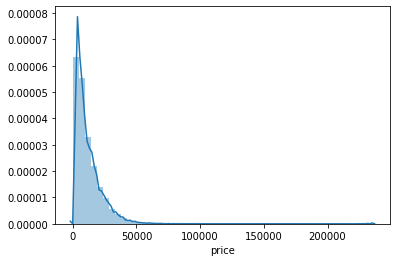

In [27]:
sns.distplot(data['price'])

In [28]:
data['price_log'] = np.log(data['price'])

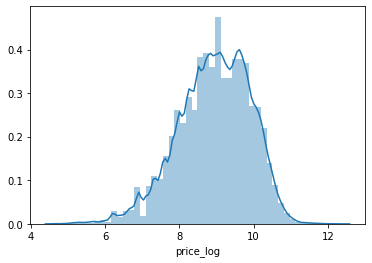

In [29]:
sns.distplot(data['price_log'])

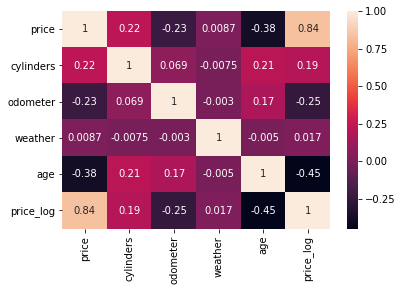

In [30]:
sns.heatmap(data.corr(), annot = True)

In [31]:
# price_log has strongest negative coreliation with  age and odometer and positive correliation is strongest with cylinders

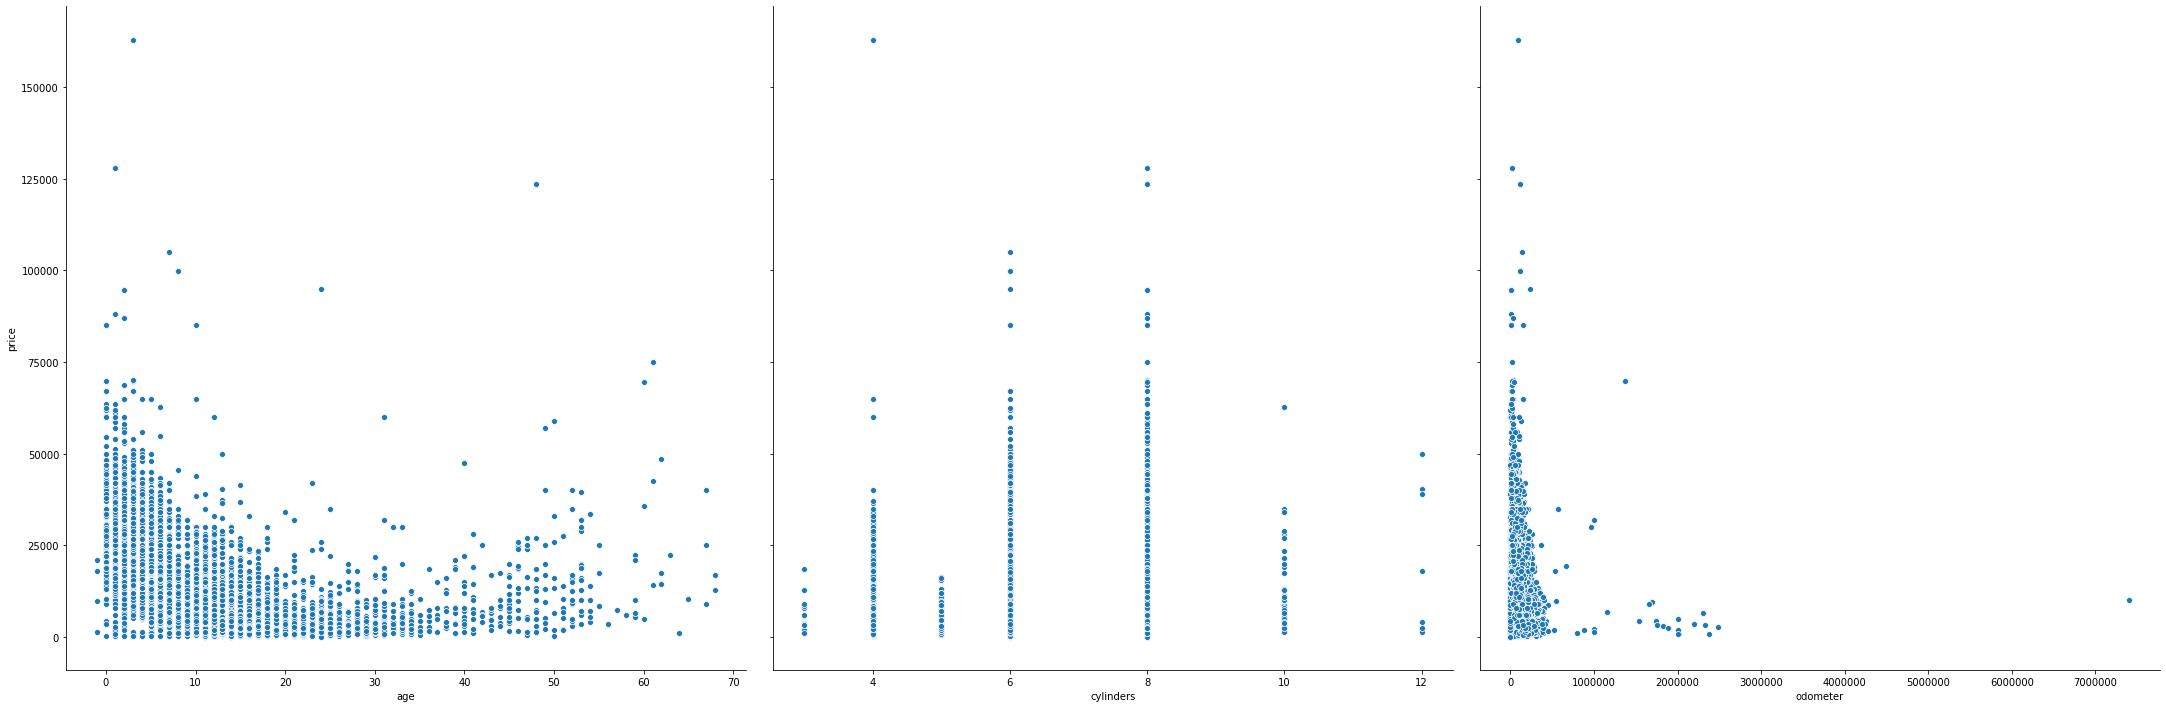

In [32]:
sns.pairplot(data.sample(10000), height = 10,
             y_vars = ['price'],
             x_vars = ['age', 'cylinders', 'odometer'])

# LINEAR REGRESSION

In [33]:
feature_cols = ['age', 'odometer', 'cylinders']

In [34]:
X = data[feature_cols]
y = data[['price_log']]

In [35]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.2)

In [36]:
linear = LinearRegression() 

In [37]:
linear.fit(X_train, y_train)
accuracy = linear.score(X_test, y_test)
print(accuracy)

0.3276968208311122


In [38]:
print(linear.intercept_)
print(linear.coef_)

[8.56520496]
[[-5.43575309e-02 -1.24156670e-06  1.87883140e-01]]


In [39]:
predictions = linear.predict(X_test)

In [40]:
predictions

array([[9.68535599],
       [9.68765562],
       [8.61467423],
       ...,
       [8.62320404],
       [9.24091111],
       [8.80179104]])

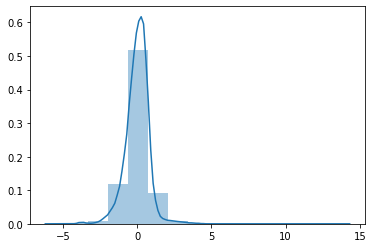

In [41]:
sns.distplot(y_test - predictions, bins = 15)

In [42]:
est = smf.ols('price_log ~ age + odometer + cylinders', data).fit()

In [43]:
est.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              price_log   R-squared:                       0.324
Model:                            OLS   Adj. R-squared:                  0.324
Method:                 Least Squares   F-statistic:                 8.571e+04
Date:                Wed, 11 Sep 2019   Prob (F-statistic):               0.00
Time:                        11:09:53   Log-Likelihood:            -6.4116e+05
No. Observations:              537080   AIC:                         1.282e+06
Df Residuals:                  537076   BIC:                         1.282e+06
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      8.5667      0.004   1971.110      0.000       8.558       8.575
age           -0.0544      0.000   -416.284      0.000      -0.055      -0.054
odometer   -1.275e-06   7.76e-09   -164.411      0.000   -1.29e-06   -1.26e-06
cylinders      0.1883      0.001    268.495      0.000       0.187       0.190
==============================================================================
Omnibus:                    93819.157   Durbin-Watson:                   1.063
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1987687.706
Skew:                           0.209   Prob(JB):                         0.00
Kurtosis:                      12.415   Cond. No.                     7.48e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 7.48e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [ ]:
# Simple linear regresion model is unsuitable for ths data, 
# because it explains only small amount of variation, but all chosen variables are significant

# CLUSTERING

In [75]:
data_conv = data.copy()

In [76]:
# creating dummy variable for manufacturer, fuel, transmission,  drive, type, paint_color 
manufacturers = pd.get_dummies(data_conv['manufacturer'], prefix = 'manufacturer', drop_first=True)
fuels = pd.get_dummies(data_conv['fuel'], prefix = 'fuel', drop_first=True)
transmissions = pd.get_dummies(data_conv['transmission'], prefix = 'transmission', drop_first=True)
drives = pd.get_dummies(data_conv['drive'], prefix = 'drive', drop_first=True)
types = pd.get_dummies(data_conv['type'], prefix = 'type', drop_first=True)
paint_colors = pd.get_dummies(data_conv['paint_color'], prefix = 'paint_color', drop_first=True)

In [77]:
data_conv = pd.concat([data_conv, manufacturers, fuels, transmissions, drives, types, paint_colors], axis = 1)

In [78]:
data_conv.shape

(537080, 93)

In [79]:
data_conv.drop(['state_name', 'manufacturer', 'fuel', 'transmission', 'drive', 'type', 'paint_color'], axis = 1, inplace = True)

In [80]:
data_conv.head()

,price,cylinders,odometer,weather,age,price_log,Cluster,manufacturer_acura,manufacturer_alfa-romeo,manufacturer_aston-martin,...,paint_color_brown,paint_color_custom,paint_color_green,paint_color_grey,paint_color_orange,paint_color_purple,paint_color_red,paint_color_silver,paint_color_white,paint_color_yellow
3514,11900,6,43600.0,38.0,8,9.384294,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
3517,2800,6,168591.0,47.0,14,7.937375,4,0,0,0,...,0,0,0,1,0,0,0,0,0,0
3520,12500,4,39500.0,38.0,3,9.433484,7,0,0,0,...,0,0,0,1,0,0,0,0,0,0
3611,2850,8,14000.0,51.0,36,7.955074,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
3613,8100,6,100098.0,67.0,9,8.999619,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0


In [81]:
ss = StandardScaler()
ss.fit(data_conv)
data_conv = ss.transform(data_conv)

In [92]:
km = KMeans(n_clusters = 10)
km = km.fit(data_conv)

In [93]:
data['Cluster'] = km.labels_
data.head()

,state_name,manufacturer,price,cylinders,fuel,odometer,transmission,drive,type,paint_color,weather,age,price_log,Cluster
3514,South Dakota,dodge,11900,6,gas,43600.0,automatic,rwd,coupe,red,38.0,8,9.384294,5
3517,Iowa,ford,2800,6,gas,168591.0,automatic,fwd,sedan,grey,47.0,14,7.937375,1
3520,South Dakota,jeep,12500,4,gas,39500.0,automatic,4wd,SUV,grey,38.0,3,9.433484,8
3611,Kansas,chevrolet,2850,8,gas,14000.0,manual,rwd,pickup,red,51.0,36,7.955074,2
3613,Texas,cadillac,8100,6,gas,100098.0,automatic,rwd,sedan,red,67.0,9,8.999619,2


In [90]:
sum_of_squared_distances = []

k_range = range(1, 15)

for k in k_range:
    km = KMeans(n_clusters = k)
    km = km.fit(data_conv)
    sum_of_squared_distances.append(km.inertia_)

Text(0, 0.5, 'sum_of_squared_distances')

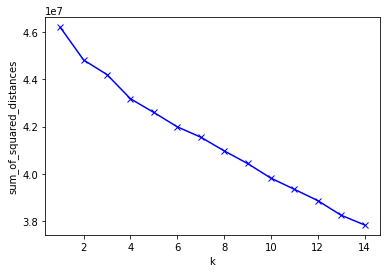

In [91]:
plt.plot(k_range, sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('sum_of_squared_distances')

In [ ]:
# elbow on 10

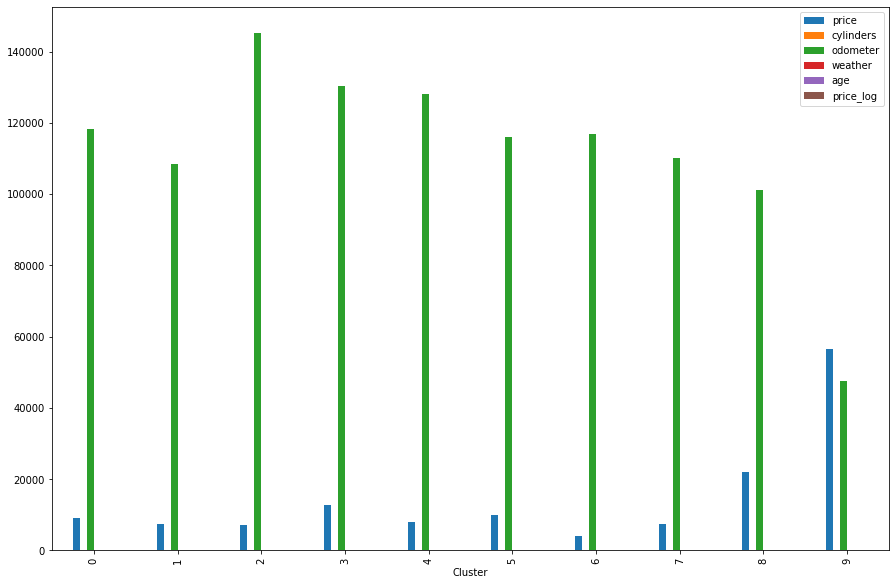

In [94]:
means = data.groupby('Cluster').mean()
means.plot(kind = 'bar', figsize = [15,10])